In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import timedelta
from keras.models import Sequential,load_model
from keras.layers import Embedding, Flatten, Dense, LSTM
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
with open('second-pickle.pickle', 'rb') as f:
     df1,df2,df3 = pickle.load(f)

In [3]:
print(df1)
print(df2)
print(df3)

['I-30 E', 'I-35E S', 'Warren Pkwy', 'I-820 E', 'Sutter St', 'US-67 S', 'I-20 W', 'University Dr', 'US-75 N', 'Dallas North Tollway N', 'FM 423', 'Exit 29: President George Bush Tpk N', 'I-35W N', 'Exit 18: Oakland Blvd', 'US-75 S', 'SH-183 W', 'I-635 W', 'SH-360 S', 'I-20 E', 'to I-635 E', 'N Henderson Ave', 'I-35E N', 'US-80 W', 'US-287 S', 'I-30 W', 'Cimarron Trl', 'Loop 12 S', 'I-635 E', 'Cupertino Trl', 'W Northwest Hwy', 'Elm St', 'North Texas Blvd', 'Eldorado Pkwy', 'Circle Ln', 'N Stemmons Fwy', nan, 'Coit Rd', 'Continental Ave', 'I-35 N', 'Meadowview Dr', 'Sunrise Dr', 'W Hebron Pkwy', 'Young St', 'Allen St', 'Rendon New Hope Rd', 'US-80 E', 'W Lawther Dr', 'Morton St', 'Exit 54A: SH-183 / NE 28th St E', 'W Rosedale St', 'Willis Ave', 'Lamar St', 'Forest Park Blvd', 'to Montfort Dr', 'French Wood Dr', 'E Trinity Mills Rd', 'E Pioneer Pkwy', 'to US-75 S', 'SH-114', 'to Oakmont Blvd', 'Dowdy Ferry Rd', 'E Belt Line Rd', 'N Marsalis Ave', 'SH-114 E', 'US-175 E', 'FM 2499', 'Hawes

In [4]:
sq=[]
for road in df1:
    temp_df=df3[df3['FACILITY_NAME'] == road]
    time=list(temp_df[(temp_df['EVENT_TYPE'].isin(["accident","minor accident"]))].time)
    for item in time:
        stim= item -timedelta(minutes=30)
        maske = ((temp_df['time'] >= stim) & (temp_df['time'] <= item) & (temp_df['EVENT_TYPE'] != "accident") & (temp_df['EVENT_TYPE'] != "minor accident"))
        dfse=temp_df.loc[maske]
        dfse=dfse.reset_index(drop=True)
        s1=[]
        for i in range(len(dfse)-1):
            s1.append(dfse['EVENT_TYPE'].loc[i])
        sq.append(s1)
accident = []

for sequence in sq:
    if len(sequence) != 0:
        accident.append(sequence)

In [5]:
df_na = df3[(df3['EVENT_TYPE'] != 'accident') & (df3['EVENT_TYPE'] != 'minor accident')].sample(n=32220, random_state=5)
sq_na=[]
for index in range(len(df_na)):
    road=df_na['FACILITY_NAME'].iloc[index]
    temp_df=df3[df3['FACILITY_NAME'] == road]
    etime_na=df_na['time'].iloc[index]
    stime_na= etime_na -timedelta(minutes=30)
    mask_na = ((temp_df['time'] >= stime_na) & (temp_df['time'] <= etime_na))
    dfuse_na=temp_df.loc[mask_na]
    dfuse_na=dfuse_na.reset_index(drop=True)
    s1=[]
    for i in range(len(dfuse_na)-1):
        s1.append(dfuse_na['EVENT_TYPE'].loc[i])
    sq_na.append(s1)
not_accident = []

for sequence in sq_na:
    if len(sequence) != 0:
        not_accident.append(sequence)

In [6]:
dtemp1=pd.DataFrame({'label':1, 'events': accident})
dtemp2 = pd.DataFrame({'label':0, 'events': not_accident})
dtemp1=dtemp1.sample(n=len(dtemp2), random_state=12)
fdf=pd.concat([dtemp1, dtemp2])
fdf.reset_index(inplace=True,drop=True)

In [7]:
event_dict={}
for i in range(len(df2)):
    event_dict.update({ i+1 : df2[i]})
max_len_event_id = fdf.events.apply(len).idxmax()
max_len_event = fdf.iloc[max_len_event_id]
maxlen = len(max_len_event.events)

reversed_dict = {}

for k, v in event_dict.items():
  reversed_dict[v] = k

def event_list_to_index(event_list):
  list_idxs = []
  for event in (event_list):
    idx = reversed_dict[event]
    list_idxs.append(idx)
  return list_idxs

In [8]:
sequences = fdf.events.apply(event_list_to_index).tolist()
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.array(fdf.label)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
training_samples = int(len(indices) * .8)
validation_samples = len(indices) - training_samples
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]
num_events = len(event_dict) + 1
embedding_dim = 20
embedding_matrix = np.random.rand(num_events, embedding_dim)

In [9]:
units = 32

model = Sequential()
model.add(Embedding(num_events, embedding_dim))
model.add(LSTM(units, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))


model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_valid, y_valid))
model.save("traffic.h5")



Epoch 1/20


77/77 [==============================] - 42s 521ms/step - loss: 0.6594 - acc: 0.6121 - val_loss: 0.6452 - val_acc: 0.6356
Epoch 2/20
77/77 [==============================] - 40s 522ms/step - loss: 0.6429 - acc: 0.6377 - val_loss: 0.6395 - val_acc: 0.6393
Epoch 3/20
77/77 [==============================] - 41s 530ms/step - loss: 0.6369 - acc: 0.6427 - val_loss: 0.6339 - val_acc: 0.6475
Epoch 4/20
77/77 [==============================] - 189s 2s/step - loss: 0.6329 - acc: 0.6483 - val_loss: 0.6316 - val_acc: 0.6501
Epoch 5/20
77/77 [==============================] - 35s 457ms/step - loss: 0.6282 - acc: 0.6521 - val_loss: 0.6279 - val_acc: 0.6570
Epoch 6/20
77/77 [==============================] - 37s 484ms/step - loss: 0.6217 - acc: 0.6610 - val_loss: 0.6197 - val_acc: 0.6665
Epoch 7/20
77/77 [==============================] - 40s 525ms/step - loss: 0.6134 - acc: 0.6709 - val_loss: 0.6124 - val_acc: 0.6784
Epoch 8/20
77/77 [==============================] - 36s 471ms/step 

C:\Users\ahmed\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


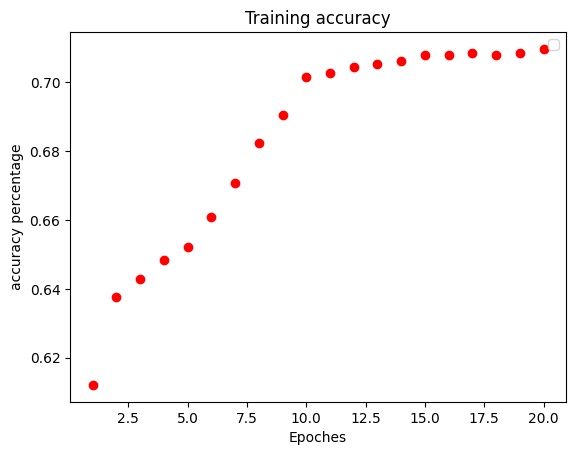

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'ro')
plt.title('Training accuracy')
plt.legend()
plt.xlabel('Epoches')
plt.ylabel('accuracy percentage')

plt.show()

In [11]:
model = load_model("traffic.h5")

def permutation_importance(model, X_valid, y_valid, metric, seed=None):

    original_performance = metric(y_valid, model.predict(X_valid).round())


    importances = np.zeros(X_valid.shape[1])

    for i in range(X_valid.shape[1]-20,X_valid.shape[1]):

        original_column = X_valid[:, i].copy()


        np.random.seed(seed)
        X_valid[:, i] = np.random.permutation(X_valid[:, i])


        new_performance = metric(y_valid, model.predict(X_valid).round())


        X_valid[:, i] = original_column


        importances[i] = original_performance - new_performance

    return importances

feature_importances = permutation_importance(model, X_train, y_train, accuracy_score)


for i, imp in enumerate(feature_importances):
    print(f"Feature {i}: Importance {imp}")

1224/1224 [==============================] - 16s 13ms/step
Feature 0: Importance 0.0
Feature 1: Importance 0.0
Feature 2: Importance 0.0
Feature 3: Importance 0.0
Feature 4: Importance 0.0
Feature 5: Importance 0.0
Feature 6: Importance 0.0
Feature 7: Importance 0.0
Feature 8: Importance 0.0
Feature 9: Importance 0.0
Feature 10: Importance 0.0
Feature 11: Importance 0.0
Feature 12: Importance 0.0
Feature 13: Importance 0.0
Feature 14: Importance 0.0
Feature 15: Importance 0.0
Feature 16: Importance 0.0
Feature 17: Importance 0.0
Feature 18: Importance 0.0
Feature 19: Importance 0.0
Feature 20: Importance 0.0
Feature 21: Importance 0.0
Feature 22: Importance 0.0
Feature 23: Importance 0.0
Feature 24: Importance 0.0
Feature 25: Importance 0.0
Feature 26: Importance 0.0
Feature 27: Importance 0.0
Feature 28: Importance 0.0
Feature 29: Importance 0.0
Feature 30: Importance 0.0
Feature 31: Importance 0.0
Feature 32: Importance 0.0
Feature 33: Importance 0.0
Feature 34: Importance 0.0
Featur

In [20]:
event_dict

{1: 'minor accident',
 2: 'other',
 3: 'road closed',
 4: 'stopped car on the shoulder',
 5: 'traffic jam',
 6: 'major event',
 7: 'pothole',
 8: 'missing sign on the shoulder',
 9: 'stopped car',
 10: 'hazard on the shoulder',
 11: 'accident',
 12: 'flooding',
 13: 'road construction',
 14: 'stopped traffic',
 15: 'object on roadway',
 16: 'animal struck',
 17: 'heavy traffic',
 18: 'small traffic jam',
 19: 'slowdown',
 20: 'animal on the shoulder',
 21: 'large traffic jam',
 22: 'traffic heavier than normal',
 23: 'malfunctioning traffic light',
 24: 'medium traffic jam',
 25: 'hazard on road',
 26: 'weather hazard',
 27: 'road closed due to construction',
 28: 'hail',
 29: 'ice on roadway',
 30: 'fog',
 31: 'huge traffic jam',
 32: 'road closed due to hazard',
 0: 'N\\A'}

In [22]:
test = []
for i in range(33):
    for j in range(33):
        for k in range(33):
            if(i != 1 and i!=11 and j != 1 and j!=11 and k != 1 and k!=11):
                test.append([i,j,k])
predictions = model.predict(test)

931/931 [==============================] - 1s 914us/step


In [23]:
data_df = pd.DataFrame(test,columns=['Event1','Event2','Event3'])
labels_df = pd.DataFrame(predictions, columns=['Label'])

result = pd.concat([data_df, labels_df], axis=1)

result =result.sort_values(by='Label', ascending=False)
result.reset_index(inplace=True, drop=True)

In [24]:
event_dict.update({ 0 : "N\A"})

In [25]:
for i in result[:20].index:
    print(f"[{event_dict[(result['Event3'][i])]} , {event_dict[result['Event2'][i]]} , {event_dict[result['Event1'][i]]}]  has accident probability of {result['Label'][i]}\n")

[major event , major event , major event]  has accident probability of 0.9046555757522583

[major event , stopped car , major event]  has accident probability of 0.8822758793830872

[major event , major event , N\A]  has accident probability of 0.8821588158607483

[flooding , major event , major event]  has accident probability of 0.8796165585517883

[stopped car , major event , major event]  has accident probability of 0.878257691860199

[major event , major event , animal on the shoulder]  has accident probability of 0.8776286244392395

[major event , major event , stopped car]  has accident probability of 0.8770347237586975

[major event , flooding , major event]  has accident probability of 0.8747905492782593

[major event , major event , huge traffic jam]  has accident probability of 0.8745500445365906

[major event , small traffic jam , major event]  has accident probability of 0.8711523413658142

[major event , animal on the shoulder , major event]  has accident probability of 0

In [37]:
for i in result[len(result)-1000:len(result)].index:
    if(result['Event3'][i] != 3 and result['Event2'][i] != 3 and result['Event1'][i] != 3 and result['Event3'][i] != 27 and result['Event2'][i] != 27 and result['Event1'][i] != 27 and result['Event3'][i] != 32 and result['Event2'][i] != 32 and result['Event1'][i] != 32):
        print(f"[{event_dict[(result['Event3'][i])]} , {event_dict[result['Event2'][i]]} , {event_dict[result['Event1'][i]]}]  has accident probability of {result['Label'][i]}\n")

[missing sign on the shoulder , malfunctioning traffic light , malfunctioning traffic light]  has accident probability of 0.25928977131843567

[malfunctioning traffic light , road construction , malfunctioning traffic light]  has accident probability of 0.2584719657897949

[hail , malfunctioning traffic light , malfunctioning traffic light]  has accident probability of 0.2579442262649536

[hazard on the shoulder , malfunctioning traffic light , malfunctioning traffic light]  has accident probability of 0.25576362013816833

[malfunctioning traffic light , malfunctioning traffic light , malfunctioning traffic light]  has accident probability of 0.23784498870372772

